In [1]:
import os, re
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib.axes import Axes
from scipy.stats import ttest_ind

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import anndata
import scanpy as sc
from anndata import AnnData as ad

from tools import get_statistics_of_gene, dotplot_gene_expr_and_frac

## Download processed pseudo bulk RNAseq from s3

In [3]:
process_files = pd.read_csv('biomarker_identification/pseudoBulkRNAseq/processed.TISCH2.csv', index_col=0).values.flatten()

In [2]:
files = [f'aggregated_pseudoBulk_{f}.h5ad' for f in ['DNAJB1', 'RGS1', 'LAMP3', 'NCAM1', 'FCGR3A', 'KLF6', 'EGR3']]

In [2]:
# files = ['aggregated_pseudoBulk_CD45RA.h5ad',
#  'aggregated_pseudoBulk_CCR7.h5ad',
#  'aggregated_pseudoBulk_SELL.h5ad',
#  'aggregated_pseudoBulk_CD28.h5ad',
#  'aggregated_pseudoBulk_CD44.h5ad',
#  'aggregated_pseudoBulk_FAS.h5ad',
#  'aggregated_pseudoBulk_IL7R.h5ad',
#  'aggregated_pseudoBulk_CCL4.h5ad',
#  'aggregated_pseudoBulk_GZMA.h5ad',
#  'aggregated_pseudoBulk_GZMB.h5ad',
#  'aggregated_pseudoBulk_KLRD1.h5ad',
#  'aggregated_pseudoBulk_PRF1.h5ad',
#  'aggregated_pseudoBulk_GZMK.h5ad',
#  'aggregated_pseudoBulk_KLRB1.h5ad',
#  'aggregated_pseudoBulk_SLC4A10.h5ad',
#  'aggregated_pseudoBulk_ZBTB16.h5ad',
#  'aggregated_pseudoBulk_CAPG.h5ad',
#  'aggregated_pseudoBulk_DUSP23.h5ad',
#  'aggregated_pseudoBulk_FXYD7.h5ad',
#  'aggregated_pseudoBulk_GATA3.h5ad',
#  'aggregated_pseudoBulk_GNLY.h5ad']

In [5]:
gnames = []
fnames = []
cmd = str()
for f in files: #process_files
    gnames.append(re.search(r'.*pseudoBulk_(.*?).h5ad', f).group(1))
    fnames.append(f)
    fbasename = os.path.basename(f)
    cmd += f'aws s3 cp s3://gv20deeplearning/XBH25/TISCH2_preprocessing/pseudo_bulkRNAseq_from_TISCH2_test/{fbasename}' 
    cmd += ' /Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq_minor/; '

In [6]:
os.system(cmd)

download: s3://gv20deeplearning/XBH25/TISCH2_preprocessing/pseudo_bulkRNAseq_from_TISCH2_test/aggregated_pseudoBulk_DNAJB1.h5ad to biomarker_identification/pseudoBulkRNAseq_minor/aggregated_pseudoBulk_DNAJB1.h5ad
download: s3://gv20deeplearning/XBH25/TISCH2_preprocessing/pseudo_bulkRNAseq_from_TISCH2_test/aggregated_pseudoBulk_RGS1.h5ad to biomarker_identification/pseudoBulkRNAseq_minor/aggregated_pseudoBulk_RGS1.h5ad
download: s3://gv20deeplearning/XBH25/TISCH2_preprocessing/pseudo_bulkRNAseq_from_TISCH2_test/aggregated_pseudoBulk_LAMP3.h5ad to biomarker_identification/pseudoBulkRNAseq_minor/aggregated_pseudoBulk_LAMP3.h5ad
download: s3://gv20deeplearning/XBH25/TISCH2_preprocessing/pseudo_bulkRNAseq_from_TISCH2_test/aggregated_pseudoBulk_NCAM1.h5ad to biomarker_identification/pseudoBulkRNAseq_minor/aggregated_pseudoBulk_NCAM1.h5ad
download: s3://gv20deeplearning/XBH25/TISCH2_preprocessing/pseudo_bulkRNAseq_from_TISCH2_test/aggregated_pseudoBulk_FCGR3A.h5ad to biomarker_identification/

0

## Plot setting

In [2]:
# Publication quality plots
import OncoMarkAI as oma
oma.pl.fig_setting()
cmap = oma.pl.cmap()
# sns.set_palette("deep");
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

2023-11-15 19:06:30|INFO|plotting|Figure setting updated


<Figure size 1200x900 with 0 Axes>

In [3]:
# # Publication quality plots
# from matplotlib import pylab
# params = {'legend.fontsize': 4,
#           'figure.facecolor':"w",
#           'figure.figsize': (4, 3),
#          'axes.labelsize': 6,
#          'axes.titlesize':7,
#          'axes.linewidth': 0.5, 
#          'xtick.labelsize':5,
#          'ytick.labelsize':5,
#          'pdf.fonttype': 42,
#          'figure.autolayout': True,
#          'axes.grid':False,
#          "figure.dpi":300,
#           "figure.autolayout": True
#          }
# # Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
# pylab.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10});

# # Set the font used for MathJax - more on this later
# pylab.rc('mathtext',**{'default':'regular'});

# pylab.rcParams.update(params);

# sns.set_palette("muted");
# sns.set_style("ticks");
# sns.despine(offset=10, trim=True);

# # %matplotlib inline

## Calculate psudo bulkRNAseq expression and cell fraction

In [5]:
input_list = []
for f in os.listdir('/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq_minor/'):
    if f.endswith('.h5ad'):
        gname = re.search(r'.*pseudoBulk_(.*?).h5ad', f).group(1)
        fname = os.path.join('/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq_minor', f)
        if gname in ['IGSF8', 'KLRC1', 'KIR3DL2']: #, 'LILRB2''DNAJB1', 'RGS1', 'LAMP3', 'NCAM1', 'FCGR3A', 'KLF6', 'EGR3'
            input_list.append((fname, gname))

In [6]:
input_list

[('/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq_minor/aggregated_pseudoBulk_IGSF8.h5ad',
  'IGSF8'),
 ('/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq_minor/aggregated_pseudoBulk_KIR3DL2.h5ad',
  'KIR3DL2'),
 ('/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq_minor/aggregated_pseudoBulk_KLRC1.h5ad',
  'KLRC1')]

In [8]:
# adata = sc.read('/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq/aggregated_pseudoBulk_KIR3DL2.h5ad')
# adata = adata[
#     adata.obs["Treatment"] == "None"
# ].copy()

# adata.obs.apply(lambda row: ~row[["Tissue", "Source"]].astype(str).str.contains('|'.join(search_terms), case=False).any(), axis=1)

# for i,row in filtered_df.iterrows():
#     print(row.astype(str).str.contains('|'.join(search_terms), case=False))
#     break
    

In [7]:
output = []
for p,g in input_list:
    tmp = get_statistics_of_gene(p, g, celltype_key='Celltype (minor-lineage)')
    output.append(tmp)
output = pd.concat(output)

/Users/caibin/miniconda3/envs/general/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/caibin/Documents/CodeCommit/single-cell-omics/tools/processing.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(celltype_key)
/Users/caibin/Documents/CodeCommit/single-cell-omics/tools/processing.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr = tot_adata_obs.groupby(celltype_key).describe()[f"{gene}"]
/Users/caibin/miniconda3/envs/general/lib/python3.11/si

In [18]:
output_df_subset = output.loc[:, output.columns.get_level_values(1) == "mean"]
output_df_subset.columns = output_df_subset.columns.droplevel(1)
output_df_subset = output_df_subset.reset_index()

In [19]:
output_df_subset.tail()

,genes,Celltype (minor-lineage),cell_fraction,expression_level
262,KLRC1,Treg,0.027824,0.231147
263,KLRC1,cDC1,0.005693,0.041132
264,KLRC1,cDC2,0.014156,0.099228
265,KLRC1,nan,0.020491,0.159847
266,KLRC1,pDC,0.016040,0.125655


In [10]:
[i for i in list(output_df_subset["Celltype (minor-lineage)"].unique()) if i.startswith("CD8T")]

['CD8T', 'CD8Tcm', 'CD8Teff', 'CD8Tem', 'CD8Tex', 'CD8Tn']

In [24]:
xaxis = 'genes'
# x_order = ['IGSF8', 'CDH2', 'FZR1', 'CLEC4A', 'KIR3DL2', 'CSF2RA', 'MRC1']
x_order = ['IGSF8', 'KLRC1', 'KIR3DL2']#, 'LILRB2'], 'NCAM1', 'FCGR3A', 'DNAJB1', 'RGS1', 'KLF6', 'EGR3', 'LAMP3'
 
yaxis = 'Celltype (major-lineage)'
y_order = ["CD4Tn","CD4Teff",  "Th1",  "Th2",  "Th17", "CD8Tn", "CD8Tcm", "CD8Tem", "CD8Teff", "CD8Tex","MAIT", "NK", "Malignant"]
# y_order = ["Malignant", "CD8T", "CD8Tex", "Treg", "CD4Tconv",  "NK", "B","Plasma",  "DC",  "Mono/Macro"]
# y_order = ["Mono/Macro", "pDC", "DC", "cDC1", "cDC2",  "B", "CD4Tn","CD4Teff",  "Th1",  "Th2",  "Th17", "CD8Tn", "CD8Tcm", "CD8Tem", "CD8Teff", "CD8Tex","MAIT", "NK", "Malignant"]

size_key = 'cell_fraction'
color_key = 'expression_level'

In [ ]:
import matplotlib.colors as mcolors

colors = ["#3C5488FF", "#E64B35FF"]
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', list(zip([0, 1], ["#FFFFFF", colors[1]])))

<Figure size 600x450 with 0 Axes>

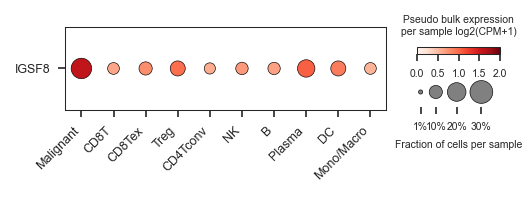

In [33]:
dotplot_gene_expr_and_frac(expr_and_frac=output_df_subset,
                           yaxis="genes",
                           xaxis="Celltype (major-lineage)",
                           y_order=x_order,
                           x_order=y_order,
                           # cmap=cmap,
                           color_lim=(0, 2),
                           figsize=(4., 1.),
                           size_factor=400,
                           size_key="cell_fraction",
                           color_key="expression_level",
                           grid_args={'dotplot_width':50, 'colorbar_width':13, 'wspace':.15},
                           legend_args={"lgd_labels": [0.01, 0.1, 0.2, 0.3], "fontsize": 5},
                           dotplot_args={"xtick_position": "bottom", "xtick_rotation": 45, "xtick_alignment": 'right', 'fontsize': 6}
                          );

plt.savefig('Dotplot_IGSF8_TISCH2_Reds_horizontal.pdf', dpi=300, bbox_inches = "tight")

<Figure size 600x450 with 0 Axes>

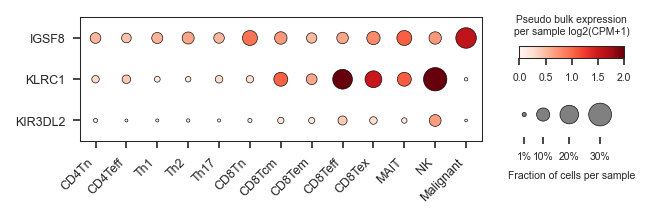

In [27]:
dotplot_gene_expr_and_frac(expr_and_frac=output_df_subset,
                           yaxis="genes",
                           xaxis="Celltype (minor-lineage)",
                           y_order=x_order,
                           x_order=y_order,
                           # cmap=cmap,
                           color_lim=(0, 2.),
                           figsize=(5., 1.5),
                           size_factor=400,
                           size_key="cell_fraction",
                           color_key="expression_level",
                           grid_args={'dotplot_width':50, 'colorbar_width':13, 'wspace':.15},
                           legend_args={"lgd_labels": [0.01, 0.1, 0.2, 0.3], "fontsize": 5},
                           dotplot_args={"xtick_position": "bottom", "xtick_rotation": 45, "xtick_alignment": 'right', 'fontsize': 6}
                          );

plt.savefig('Dotplot_IGSF8-KIR3DL2_TISCH2_Reds_horizontal_01.pdf', dpi=300, bbox_inches = "tight")

/var/folders/tf/0py1zbcx6g5_r9bpq5dw4f6h0000gn/T/ipykernel_84123/1570182407.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Dotplot_IGSF8-KIR3DL2_TISCH2_Reds_horizontal_01.pdf', dpi=300, bbox_inches = "tight")


<Figure size 600x450 with 0 Axes>

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


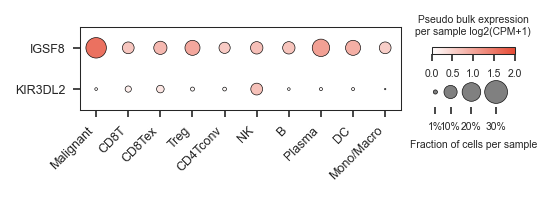

In [16]:
dotplot_gene_expr_and_frac(expr_and_frac=output_df_subset,
                           yaxis="genes",
                           xaxis="Celltype (major-lineage)",
                           y_order=x_order,
                           x_order=y_order,
                           cmap=cmap,
                           color_lim=(0, 2.),
                           figsize=(4., 1.),
                           size_factor=400,
                           size_key="cell_fraction",
                           color_key="expression_level",
                           grid_args={'dotplot_width':50, 'colorbar_width':13, 'wspace':.15},
                           legend_args={"lgd_labels": [0.01, 0.1, 0.2, 0.3], "fontsize": 5},
                           dotplot_args={"xtick_position": "bottom", "xtick_rotation": 45, "xtick_alignment": 'right', 'fontsize': 6}
                          );

plt.savefig('Dotplot_IGSF8-KIR3DL2_TISCH2_Reds_horizontal_01.pdf', dpi=300, bbox_inches = "tight")

In [75]:
import OncoMarkAI as oma
oma.pl.fig_setting()
cmap = oma.pl.cmap()
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

2023-06-06 12:58:47|INFO|plotting|Figure setting updated


<Figure size 1200x900 with 0 Axes>

In [107]:
adata_IGSF8 = sc.read("/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq/aggregated_pseudoBulk_IGSF8.h5ad")
adata_KIR3DL2 = sc.read("/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq/aggregated_pseudoBulk_KIR3DL2.h5ad")

adata_IGSF8 = adata_IGSF8[~adata_IGSF8.obs_names.str.contains("IGSF8")]
adata_IGSF8 = adata_IGSF8[adata_IGSF8.obs["Celltype (major-lineage)"] == "Malignant"]
adata_IGSF8 = adata_IGSF8[:, "IGSF8"]
IGSF8 = adata_IGSF8.to_df().join(adata_IGSF8.obs)
adata_KIR3DL2 = adata_KIR3DL2[~adata_KIR3DL2.obs_names.str.contains("KIR3DL2")]
adata_KIR3DL2 = adata_KIR3DL2[adata_KIR3DL2.obs["Celltype (major-lineage)"] == "NK"]
adata_KIR3DL2 = adata_KIR3DL2[~adata_KIR3DL2.obs["Tissue"].isin(["Normal", "PBMC"])]
adata_KIR3DL2 = adata_KIR3DL2[:, "KIR3DL2"]
KIR3DL2 = adata_KIR3DL2.to_df().join(adata_KIR3DL2.obs)

In [22]:
adata_KIR3DL2.obs

,Cells,Dataset Name,Patient,Celltype (major-lineage),Tissue,Source,TimePoint,batch,Species,Treatment,Platform,Diseases,PMID,GSE
LIHC_GSE179795#Pt63#NK#Tumor-3,689,LIHC_GSE179795,Pt63,NK,Tumor,NaN,NaN,3,Human,None,10x Genomics,Human_LIHC,34340996,GSE179795
OSCC_GSE172577#patient1#NK#Tumor-5,121,OSCC_GSE172577,patient1,NK,NaN,Tumor,NaN,5,Human,None,10x Genomics,Human_OSCC,34044317,GSE172577
OSCC_GSE172577#patient2#NK#Tumor-5,1760,OSCC_GSE172577,patient2,NK,NaN,Tumor,NaN,5,Human,None,10x Genomics,Human_OSCC,34044317,GSE172577
OSCC_GSE172577#patient3#NK#Tumor-5,40,OSCC_GSE172577,patient3,NK,NaN,Tumor,NaN,5,Human,None,10x Genomics,Human_OSCC,34044317,GSE172577
OSCC_GSE172577#patient4#NK#Tumor-5,23,OSCC_GSE172577,patient4,NK,NaN,Tumor,NaN,5,Human,None,10x Genomics,Human_OSCC,34044317,GSE172577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GIST_GSE162115#G1#NK#Tumor-135,2476,GIST_GSE162115,G1,NK,Tumor,NaN,NaN,135,Human,Targeted therapy,10x Genomics,Human_GIST,33393143,GSE162115
GIST_GSE162115#G2#NK#Tumor-135,1264,GIST_GSE162115,G2,NK,Tumor,NaN,NaN,135,Human,Targeted therapy,10x Genomics,Human_GIST,33393143,GSE162115
PAAD_GSE162708#1#NK#Metastatic-136,4,PAAD_GSE162708,1,NK,Metastatic,NaN,NaN,136,Human,None,10x Genomics,Human_PAAD,34671197,GSE162708
PAAD_GSE162708#4#NK#Tumor-136,32,PAAD_GSE162708,4,NK,Tumor,NaN,NaN,136,Human,None,10x Genomics,Human_PAAD,34671197,GSE162708


In [108]:
IGSF8_KIR3DL2 = KIR3DL2.set_index(["Dataset Name", "Patient"]).join(IGSF8.set_index(["Dataset Name", "Patient"]), rsuffix='_IGSF8')
IGSF8_KIR3DL2 = IGSF8_KIR3DL2[["KIR3DL2", "IGSF8"]].dropna()#.corr(method="pearson")

In [109]:
from scipy import stats
rho, p = stats.pearsonr(IGSF8_KIR3DL2["KIR3DL2"], IGSF8_KIR3DL2["IGSF8"])

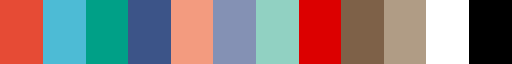

In [49]:
cmap.npg_palette

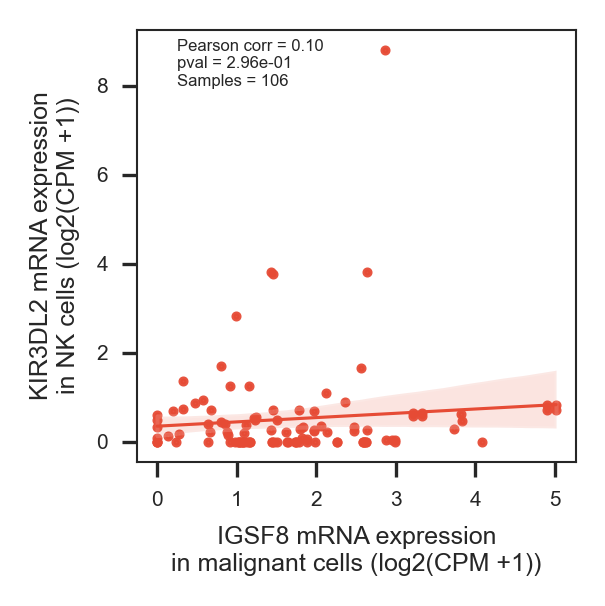

In [111]:
plt.figure(figsize=(2,2))
ax = sns.regplot(data = IGSF8_KIR3DL2,
                 x = "IGSF8",
                 y = "KIR3DL2",
                 marker='o',
                 color=cmap.npg_palette(0),
                 scatter_kws={'s':2, "alpha": .95},
                 line_kws={'lw':.75, "color": cmap.npg_palette(0)},
                 # lw = 1
                    )
ax.text(.25, 8, f"Pearson corr = {rho:.2f}\npval = {p:.2e}\nSamples = {IGSF8_KIR3DL2.shape[0]}", fontsize=4)
ax.set(xlabel=("IGSF8 mRNA expression\nin malignant cells (log2(CPM +1))"), ylabel=("KIR3DL2 mRNA expression\nin NK cells (log2(CPM +1))"))
plt.savefig("IGSF8_KIR3DL2.pdf")

In [82]:
adata_IGSF8 = sc.read("/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq/aggregated_pseudoBulk_IGSF8.h5ad")
adata_KIR3DL2 = sc.read("/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq/aggregated_pseudoBulk_KIR3DL2.h5ad")

adata_IGSF8 = adata_IGSF8[~adata_IGSF8.obs_names.str.contains("IGSF8")]
adata_IGSF8 = adata_IGSF8[adata_IGSF8.obs["Celltype (major-lineage)"] == "Malignant"]
adata_IGSF8.obs['MHCI'] = adata_IGSF8[:, ["HLA-A", "HLA-B", "HLA-C", "B2M", "TAP1", "TAP2"]].to_df().mean(axis=1)

/var/folders/tf/0py1zbcx6g5_r9bpq5dw4f6h0000gn/T/ipykernel_35453/3399129078.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_IGSF8.obs['MHCI'] = adata_IGSF8[:, ["HLA-A", "HLA-B", "HLA-C", "B2M", "TAP1", "TAP2"]].to_df().mean(axis=1)


In [84]:
MHC_IGSF8 = adata_IGSF8[:, "IGSF8"].to_df().join(adata_IGSF8.obs['MHCI'])

In [87]:
rho, p = stats.pearsonr(MHC_IGSF8["MHCI"], MHC_IGSF8["IGSF8"])

In [103]:
MHC_IGSF8.shape

(629, 2)

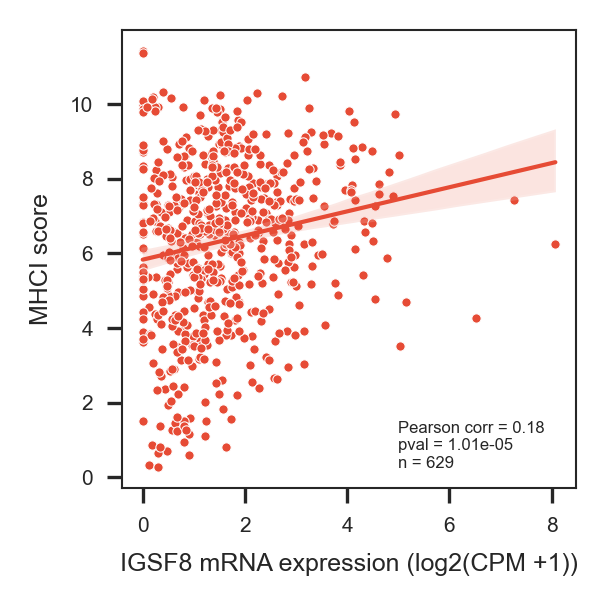

In [106]:
plt.figure(figsize=(2,2))
ax = sns.regplot(data = MHC_IGSF8,
                 x = "IGSF8",
                 y = "MHCI",
                 marker='o',
                 color=cmap.npg_palette(0),
                 scatter_kws={'s':5, "alpha": 1, 'edgecolor': 'white', "linewidth": .25},
                 line_kws={'lw':1, "color": cmap.npg_palette(0)},
                 # lw = 1
                    )
ax.text(5, .25, f"Pearson corr = {rho:.2f}\npval = {p:.2e}\nn = {MHC_IGSF8.shape[0]}", fontsize=4)
ax.set(xlabel=("IGSF8 mRNA expression (log2(CPM +1))"), ylabel=("MHCI score"))
plt.savefig("IGSF8_MHCI.pdf")

In [ ]:
adata_IGSF8 = adata_IGSF8[:, "IGSF8"]
IGSF8 = adata_IGSF8.to_df().join(adata_IGSF8.obs)

In [24]:
IGSF8_KIR3DL2

KIR3DL2  Cells Celltype (major-lineage)   
Dataset Name   Patient                                                
AEL_GSE142213  AYL050           NaN    561                       NK  \
               OX1164           NaN    325                       NK   
ALL_GSE153697  B_ALL            NaN     45                       NK   
ALL_GSE154109  P1          0.945905    183                       NK   
               P2          1.367810     53                       NK   
...                             ...    ...                      ...   
SKCM_GSE148190 K411        0.233017    356                       NK   
               K411        0.000000     20                       NK   
               pilot2      0.000000    150                       NK   
SKCM_GSE179373 Patient 16  0.000000    378                       NK   
               Patient 17  0.000000      1                       NK   

                               Tissue Source TimePoint batch Species   
Dataset Name   Patient                                                 
AEL_GSE142213  AYL050             NaN  Tumor       NaN   109   Human  \
               OX1164             NaN  Tumor       NaN   109   Human   
ALL_GSE153697  B_ALL            Tumor    NaN       NaN    19   Human   
ALL_GSE154109  P1               Tumor    NaN       NaN    25   Human   
               P2               Tumor    NaN       NaN    25   Human   
...                               ...    ...       ...   ...     ...   
SKCM_GSE148190 K411               NaN    tLN       NaN    28   Human   
               K411               NaN   PBMC       NaN    28   Human   
               pilot2             NaN    tLN       NaN    28   Human   
SKCM_GSE179373 Patient 16  Metastatic    NaN       NaN    85   Human   
               Patient 17  Metastatic    NaN       NaN    85   Human   

                               Treatment               Platform  ...   
Dataset Name   Patient                                           ...   
AEL_GSE142213  AYL050               None           10x Genomics  ...  \
               OX1164               None           10x Genomics  ...   
ALL_GSE153697  B_ALL       Immunotherapy           10x Genomics  ...   
ALL_GSE154109  P1                   None           10x Genomics  ...   
               P2                   None           10x Genomics  ...   
...                                  ...                    ...  ...   
SKCM_GSE148190 K411                 None           10x Genomics  ...   
               K411                 None           10x Genomics  ...   
               pilot2               None           10x Genomics  ...   
SKCM_GSE179373 Patient 16           None  10x Genomics/CITE-seq  ...   
               Patient 17           None  10x Genomics/CITE-seq  ...   

                          Source_IGSF8 Tissue_IGSF8 TimePoint_IGSF8   
Dataset Name   Patient                                                
AEL_GSE142213  AYL050            Tumor          NaN             NaN  \
               OX1164            Tumor          NaN             NaN   
ALL_GSE153697  B_ALL               NaN        Tumor             NaN   
ALL_GSE154109  P1                  NaN        Tumor             NaN   
               P2                  NaN        Tumor             NaN   
...                                ...          ...             ...   
SKCM_GSE148190 K411                NaN          NaN             NaN   
               K411                NaN          NaN             NaN   
               pilot2              NaN          NaN             NaN   
SKCM_GSE179373 Patient 16          NaN          NaN             NaN   
               Patient 17          NaN          NaN             NaN   

                           batch_IGSF8  Species_IGSF8 Treatment_IGSF8   
Dataset Name   Patient                                                  
AEL_GSE142213  AYL050               87          Human            None  \
               OX1164               87          Human            None   
ALL_GSE153697 

In [22]:
adata_IGSF8.var

,hgnc_id-0,name-0,locus_group-0,locus_type-0,status-0,location-0,alias_symbols_all-0,hgnc_id-1,name-1,locus_group-1,...,status-98,location-98,alias_symbols_all-98,hgnc_id-99,name-99,locus_group-99,locus_type-99,status-99,location-99,alias_symbols_all-99
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,HGNC:5,alpha-1-B glycoprotein,protein-coding gene,gene with protein product,Approved,19q13.43,['A1BG'],HGNC:5,alpha-1-B glycoprotein,protein-coding gene,...,Approved,19q13.43,['A1BG'],HGNC:5,alpha-1-B glycoprotein,protein-coding gene,gene with protein product,Approved,19q13.43,['A1BG']
A1BG-AS1,HGNC:37133,A1BG antisense RNA 1,non-coding RNA,"RNA, long non-coding",Approved,19q13.43,"['A1BGAS', 'FLJ23569', 'NCRNA00181', 'A1BG-AS'...",HGNC:37133,A1BG antisense RNA 1,non-coding RNA,...,Approved,19q13.43,"['A1BGAS', 'FLJ23569', 'NCRNA00181', 'A1BG-AS'...",HGNC:37133,A1BG antisense RNA 1,non-coding RNA,"RNA, long non-coding",Approved,19q13.43,"['A1BGAS', 'FLJ23569', 'NCRNA00181', 'A1BG-AS'..."
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,HGNC:7,alpha-2-macroglobulin,protein-coding gene,gene with protein product,Approved,12p13.31,"['S863-7', 'A2M', 'CPAMD5', 'FWP007']",NaN,NaN,NaN,...,Approved,12p13.31,"['S863-7', 'A2M', 'CPAMD5', 'FWP007']",HGNC:7,alpha-2-macroglobulin,protein-coding gene,gene with protein product,Approved,12p13.31,"['S863-7', 'A2M', 'CPAMD5', 'FWP007']"
A2M-AS1,HGNC:27057,A2M antisense RNA 1,non-coding RNA,"RNA, long non-coding",Approved,12p13.31,['A2M-AS1'],HGNC:27057,A2M antisense RNA 1,non-coding RNA,...,Approved,12p13.31,['A2M-AS1'],HGNC:27057,A2M antisense RNA 1,non-coding RNA,"RNA, long non-coding",Approved,12p13.31,['A2M-AS1']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,HGNC:32058,"zyg-11 family member A, cell cycle regulator",protein-coding gene,gene with protein product,Approved,1p32.3,"['ZYG11A', 'ZYG11']"
ZYG11B,HGNC:25820,"zyg-11 family member B, cell cycle regulator",protein-coding gene,gene with protein product,Approved,1p32.3,"['FLJ13456', 'ZYG11B', 'ZYG11']",HGNC:25820,"zyg-11 family member B, cell cycle regulator",protein-coding gene,...,Approved,1p32.3,"['FLJ13456', 'ZYG11B', 'ZYG11']",HGNC:25820,"zyg-11 family member B, cell cycle regulator",protein-coding gene,gene with protein product,Approved,1p32.3,"['FLJ13456', 'ZYG11B', 'ZYG11']"
ZYX,HGNC:13200,zyxin,protein-coding gene,gene with protein product,Approved,7q34,['ZYX'],HGNC:13200,zyxin,protein-coding gene,...,Approved,7q34,['ZYX'],HGNC:13200,zyxin,protein-coding gene,gene with protein product,Approved,7q34,['ZYX']


In [16]:
adata_IGSF8.obs

,Cells,Dataset Name,Patient,Celltype (major-lineage),Source,Tissue,TimePoint,batch,Species,Treatment,Platform,Diseases,PMID,GSE
KIRC_GSE145281_aPDL1#Donor1#B#PBMC-0,450,KIRC_GSE145281_aPDL1,Donor1,B,PBMC,NaN,NaN,0,Human,Immunotherapy,10x Genomics,Human_KIRC,32405063,GSE145281
KIRC_GSE145281_aPDL1#Donor1#B#PBMC#IGSF8_high-0,13,KIRC_GSE145281_aPDL1,Donor1,B,PBMC,NaN,NaN,0,Human,Immunotherapy,10x Genomics,Human_KIRC,32405063,GSE145281
KIRC_GSE145281_aPDL1#Donor1#B#PBMC#IGSF8_null-0,437,KIRC_GSE145281_aPDL1,Donor1,B,PBMC,NaN,NaN,0,Human,Immunotherapy,10x Genomics,Human_KIRC,32405063,GSE145281
KIRC_GSE145281_aPDL1#Donor1#B#Tumor-0,41,KIRC_GSE145281_aPDL1,Donor1,B,Tumor,NaN,NaN,0,Human,Immunotherapy,10x Genomics,Human_KIRC,32405063,GSE145281
KIRC_GSE145281_aPDL1#Donor1#B#Tumor#IGSF8_high-0,2,KIRC_GSE145281_aPDL1,Donor1,B,Tumor,NaN,NaN,0,Human,Immunotherapy,10x Genomics,Human_KIRC,32405063,GSE145281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRAD_GSE137829#P4#Myofibroblasts#Tumor#IGSF8_high-138,1,PRAD_GSE137829,P4,Myofibroblasts,Tumor,NaN,NaN,138,Human,None,10x Genomics,Human_PRAD,33328604,GSE137829
PRAD_GSE137829#P4#Myofibroblasts#Tumor#IGSF8_null-138,3,PRAD_GSE137829,P4,Myofibroblasts,Tumor,NaN,NaN,138,Human,None,10x Genomics,Human_PRAD,33328604,GSE137829
PRAD_GSE137829#P4#Plasma#Tumor-138,9,PRAD_GSE137829,P4,Plasma,Tumor,NaN,NaN,138,Human,None,10x Genomics,Human_PRAD,33328604,GSE137829
PRAD_GSE137829#P4#Plasma#Tumor#IGSF8_high-138,2,PRAD_GSE137829,P4,Plasma,Tumor,NaN,NaN,138,Human,None,10x Genomics,Human_PRAD,33328604,GSE137829


In [4]:
input_list = []
for f in os.listdir('/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq/'):
    if f.endswith('.h5ad'):
        gname = re.search(r'.*pseudoBulk_(.*?).h5ad', f).group(1)
        fname = os.path.join('/Users/caibin/Documents/CodeCommit/single-cell-omics/biomarker_identification/pseudoBulkRNAseq', f)
        if gname in ['CD274', 'PDCD1']: #, 'LILRB2'
            input_list.append((fname, gname))

In [6]:
output = []
for p,g in input_list:
    tmp = get_statistics_of_gene(p, g)
    output.append(tmp)
output = pd.concat(output)

In [7]:
output_df_subset = output.loc[:, output.columns.get_level_values(1) == "mean"]
output_df_subset.columns = output_df_subset.columns.droplevel(1)
output_df_subset = output_df_subset.reset_index()

In [8]:
xaxis = 'genes'
# x_order = ['IGSF8', 'CDH2', 'FZR1', 'CLEC4A', 'KIR3DL2', 'CSF2RA', 'MRC1']
x_order = ['CD274', 'PDCD1']#, 'LILRB2']

yaxis = 'Celltype (major-lineage)'
y_order = ["Malignant", "CD8T", "CD8Tex", "Treg", "CD4Tconv", "NK", "B", "Plasma", "DC", "Mono/Macro"]

size_key = 'cell_fraction'
color_key = 'expression_level'

In [10]:
import matplotlib
cmap = matplotlib.cm.Reds

/var/folders/tf/0py1zbcx6g5_r9bpq5dw4f6h0000gn/T/ipykernel_22648/4202337404.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Dotplot_CD274-PDCD1_TISCH2_Reds_bottom.pdf', dpi=300, bbox_inches = "tight")


<Figure size 600x450 with 0 Axes>

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


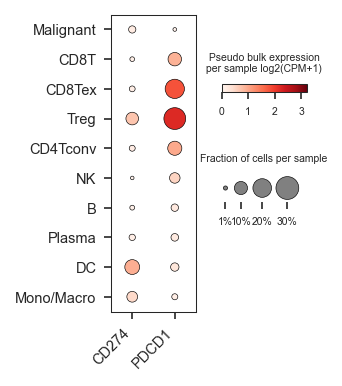

In [14]:
dotplot_gene_expr_and_frac(expr_and_frac=output_df_subset,
                           xaxis="genes",
                           yaxis="Celltype (major-lineage)",
                           x_order=x_order,
                           y_order=y_order,
                           cmap=cmap,
                           color_lim=(0, 3.2),
                           figsize=(1.8, 3.6),
                           size_factor=400,
                           size_key="cell_fraction",
                           color_key="expression_level",
                           grid_args={'dotplot_width':50, 'colorbar_width':50, 'wspace':.3},
                           legend_args={"lgd_labels": [0.01, 0.1, 0.2, 0.3], "fontsize": 5},
                           dotplot_args={"xtick_position": "bottom","xtick_rotation": 45, "xtick_alignment": 'right'}
                          );
plt.savefig('Dotplot_CD274-PDCD1_TISCH2_Reds_bottom.pdf', dpi=300, bbox_inches = "tight")

In [41]:
x_order = ["CD3E", "CD2", "TRAC","CCL5", "IL7R","CD4", "CD8B", 'GZMB','GZMA','GZMH', "GNLY", "NKG7", "KLRB1", "MS4A1","CD79A", "FCER1A", "LYZ", 'FCGR3A', 'CD14',"FCN1"]

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


<Figure size 600x450 with 0 Axes>

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


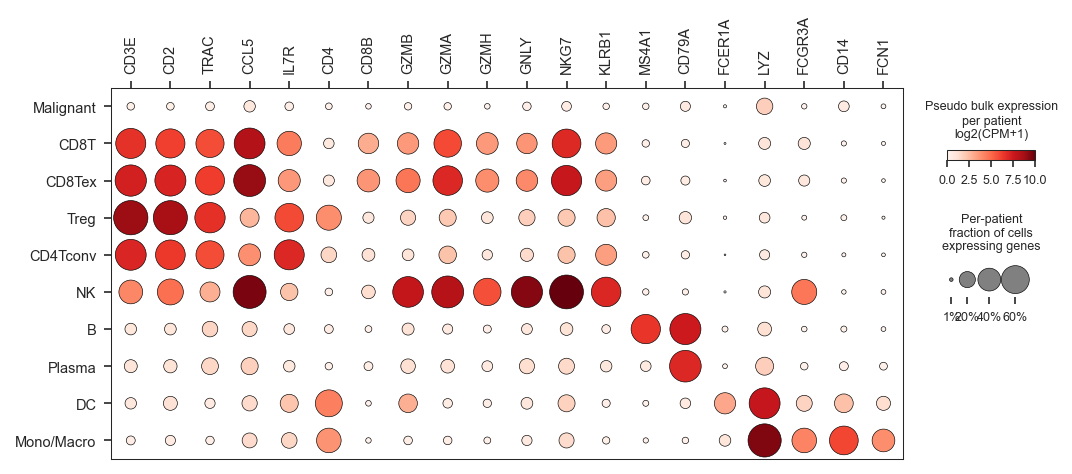

In [42]:
dotplot_gene_expr_and_frac(expr_and_frac=output_df_subset,
                           xaxis="genes",
                           yaxis="Celltype (major-lineage)",
                           x_order=x_order,
                           y_order=y_order,
                           cmap=cmap,
                           color_lim=(0, 10),
                           figsize=(8.5, 4.5),
                           size_factor=300,
                           size_key="cell_fraction",
                           color_key="expression_level",
                           grid_args={'dotplot_width':90, 'colorbar_width':10, 'wspace':.1}
                          );

In [43]:
x_order = ["CD274", "TIGIT", "MYC","LILRB1"]

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


<Figure size 600x450 with 0 Axes>

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


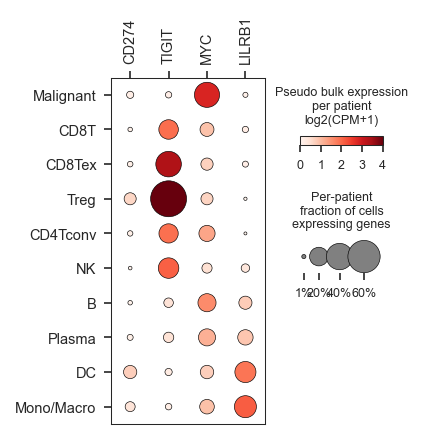

In [47]:
dotplot_gene_expr_and_frac(expr_and_frac=output_df_subset,
                           xaxis="genes",
                           yaxis="Celltype (major-lineage)",
                           x_order=x_order,
                           y_order=y_order,
                           cmap=cmap,
                           color_lim=(0, 4),
                           figsize=(2.5, 4.2),
                           size_factor=400,
                           size_key="cell_fraction",
                           color_key="expression_level",
                           grid_args={'dotplot_width':65, 'colorbar_width':35, 'wspace':.3}

                          );

## Check these genes in TCGA

In [15]:
patient_data_tcga = sc.read("/Users/caibin/Documents/CodeCommit/XBH25-paper/pan-cancer_analysis/data_curation/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad")
patient_data_tcga = patient_data_tcga[:, patient_data_tcga.var_names.isin(['IGSF8', 'KIR3DL2', 'CDH1', 'CDH2', 'CLEC4A', 'CLEC4M'])].to_df()
patient_data_tcga = patient_data_tcga.stack().to_frame('Expression (log2(TPM+1))').reset_index()

In [16]:
patient_data_tcga

,level_0,gene_name,Expression (log2(TPM+1))
0,TCGA-A4-8517-01A,CDH1,2.466026
1,TCGA-A4-8517-01A,CLEC4M,0.000000
2,TCGA-A4-8517-01A,CLEC4A,0.290154
3,TCGA-A4-8517-01A,IGSF8,6.164521
4,TCGA-A4-8517-01A,CDH2,4.984929
...,...,...,...
66733,TCGA-2Z-A9JN-01A,CLEC4M,0.016647
66734,TCGA-2Z-A9JN-01A,CLEC4A,0.100795
66735,TCGA-2Z-A9JN-01A,IGSF8,6.318037
66736,TCGA-2Z-A9JN-01A,CDH2,0.053494


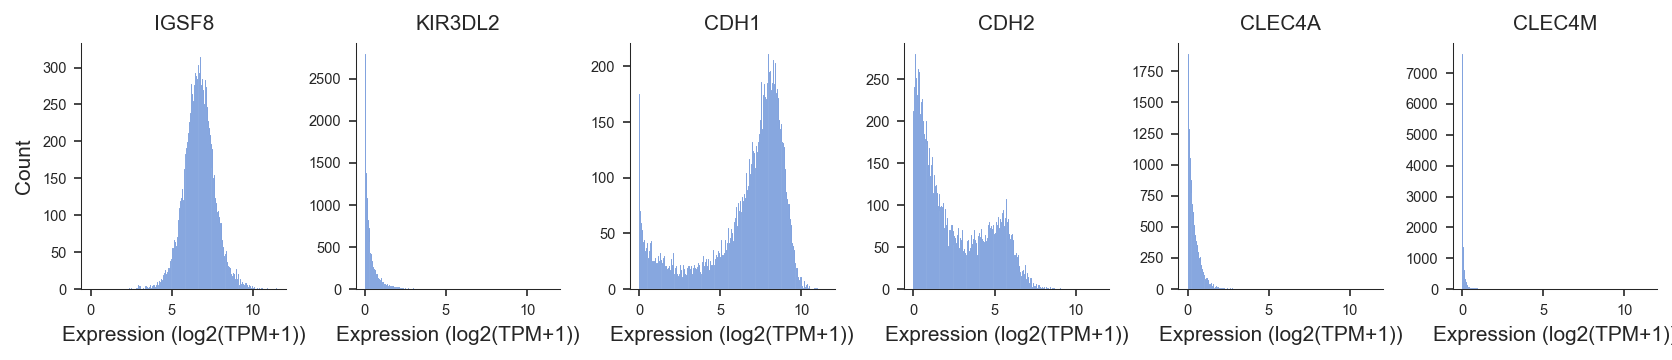

In [17]:
ax = sns.displot(data=patient_data_tcga,
                 x='Expression (log2(TPM+1))',
                 col='gene_name',
                 col_order=['IGSF8', 'KIR3DL2', 'CDH1', 'CDH2', 'CLEC4A', 'CLEC4M'],
                 kind='hist',
                 height=2.5,
                 aspect=.75,
                 bins=200,
                facet_kws={"sharey":False}
               )
ax.set_titles('{col_name}')